In [1]:
import xcell
import numpy as np
from scipy.spatial.transform import Rotation
import pyvista as pv

from matplotlib.colors import to_rgba_array

pv.global_theme.jupyter_backend='pythreejs'

#bodies, misc, oriens, and hilus
sigmas = 1/np.array([6.429,
3.215,
2.879,
2.605])

#latest from https://github.com/Head-Conductivity/Human-Head-Conductivity
sigma_0=0.3841


xdom = 5e-2

dbody = 1.3e-3
dmicro = 17e-6
wmacro = 2e-3

pitchMacro = 5e-3

nmacro = 6  # 4-6
nmicro = 24  # 10-24

microRows = 5
microCols = 3

orientation = np.array([1., 0., 0.])

tipPt = 1e-3*np.array([-5., 2., 0])
bodyL = 0.05

tpulse = 1e-3  # per phase
ipulse = 150e-6
vpulse = 1.


hippo=pv.read('./Geometry/slice77600_ext10000.vtk')
brainXform=-np.array(hippo.center)
hippo.translate(brainXform,inplace=True)

xdom = max(np.array(hippo.bounds[1::2])-np.array(hippo.bounds[::2]))


bbox = xdom * np.concatenate((-np.ones(3), np.ones(3)))

maxdepth = int(np.log2(xdom / dmicro)) + 2

sim = xcell.Simulation('test', bbox=bbox)




body = xcell.geometry.Cylinder(
    tipPt+bodyL*orientation/2, radius=dbody/2, length=bodyL, axis=orientation)

bodyMesh = pv.Cylinder(center=body.center,
                       direction=body.axis,
                       radius=body.radius,
                       height=body.length)

macroElectrodes = []
microElectrodes = []
elecMeshes = []

refPts = []
refSizes = []

for ii in range(nmacro):
    pt = tipPt+(ii+1)*pitchMacro*orientation

    geo = xcell.geometry.Cylinder(pt, dbody/2, wmacro, orientation)

    sim.addCurrentSource(0,
                         coords=pt,
                         geometry=geo)

    macroElectrodes.append(geo)

    refPts.append(geo.center)

    elecMeshes.append(pv.Cylinder(center=geo.center,
                                  direction=geo.axis,
                                  radius=geo.radius,
                                  height=geo.length,
                                  ))


for ii in range(microRows):
    rowpt = tipPt+(ii+.5)*pitchMacro*orientation

    for jj in range(microCols):
        rot = Rotation.from_rotvec(np.array([0, 2*jj/microCols*np.pi, 0]))
        microOrientation = rot.apply(0.5*dbody*np.array([0., 0., 1.]))

        geo = xcell.geometry.Disk(
            center=rowpt+microOrientation,
            radius=dmicro/2, axis=microOrientation,
            tol=0.5)

        sim.addCurrentSource(0, coords=geo.center,
                             geometry=geo)

        microElectrodes.append(geo)

        refPts.append(geo.center)
        elecMeshes.append(pv.Disc(center=geo.center,
                                  inner=0,
                                  outer=geo.radius,
                                  normal=geo.axis))


p = pv.Plotter()
p.add_mesh(hippo, opacity=0.5)
p.show_bounds()
p.add_mesh(bodyMesh, color='white')
[p.add_mesh(m, color='gold') for m in elecMeshes]
p.show(auto_close=False)

--No graphics will be displayed.


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

268283 elem


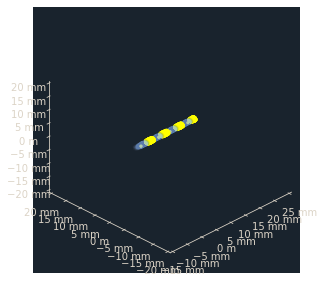

In [7]:
# %% Octree mesh visualization
sim.quickAdaptiveGrid(maxdepth)

inCyl = body.isInside(sim.mesh.nodeCoords).astype(int)
inElec = np.any([a.geometry.isInside(sim.mesh.nodeCoords)
                 for a in sim.currentSources], axis=0).astype(int)


colors = to_rgba_array([xcell.colors.NULL,
                        xcell.colors.FAINT,
                        xcell.colors.scopeColors[0]]
                       )
colors[1, -1] = 0.02

vals = inCyl+inElec

ax = xcell.visualizers.new3dPlot(bbox)

xcell.visualizers.showNodes3d(
    ax, sim.mesh.nodeCoords, vals, colors=colors[vals])

# ax.set_axis_off() #hides axes too
[a.pane.set_alpha(0) for a in [ax.xaxis, ax.yaxis, ax.zaxis]
 ]  # only hides background planes

k = 4

ax.set_xlim3d(-(k-1)*pitchMacro, (k+1)*pitchMacro)
ax.set_ylim3d(-k*pitchMacro, k*pitchMacro)
ax.set_zlim3d(-k*pitchMacro, k*pitchMacro)
ax.view_init(elev=30, azim=-135)

In [3]:
#test direct mapping
ctr=np.array([el.center for el in sim.mesh.elements])
vtk=xcell.io.toVTK(sim.mesh)
vctr=pv.wrap(ctr)

p = pv.Plotter()
p.add_mesh_slice_orthogonal(vtk,show_edges=True)
p.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

In [4]:
vpts=vtk.cell_centers()
pts=vpts.points

sigArray=sigma_0*np.ones(vpts.n_points)



files=['bodies','misc','oriens','hilus']


for f,sig in zip(files,sigmas):
    region=pv.read('Geometry/'+f+'.stl').translate(brainXform)
    
    subs=region.split_bodies()
    for subreg in subs:
        enc=vpts.select_enclosed_points(subreg.extract_surface(),progress_bar=True)
        sel=enc['SelectedPoints']==1

        sigArray[sel]=sig

# ins=vpts.select_enclosed_points(bodyMesh.extract_surface())
# body.isInside
sigArray[body.isInside(pts)]=0

vpts.cell_data['sigma']=sigArray
vpts.set_active_scalars('sigma')
vpts.save('sigmaz.vtk')

sigmesh = vtk.copy()
sigmesh.cell_data['sigma']=sigArray
sigmesh.set_active_scalars('sigma')
sigmesh.plot()

/home/benoit/anaconda3/envs/xcell/lib/python3.9/site-packages/pyvista/core/pointset.py:206: PyVistaDeprecationWarning: You did not specify a value for `inplace` and the default value will be changing to `False` in future versions for point-based meshes (e.g., `PolyData`). Please make sure you are not assuming this to be an inplace operation.
  warnings.warn(DEFAULT_INPLACE_WARNING, PyVistaDeprecationWarning)
2023-03-03 13:37:39.695 (  21.338s) [        93F15740]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2023-03-03 13:37:39.697 (  21.340s) [        93F15740]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2023-03-03 13:37:39.698 (  21.341s) [        93F15740]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
Selecting Enclosed Po

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

In [8]:
sigmesh.slice_orthogonal().plot(show_edges=True)

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

In [6]:
#test direct mapping
ctr=np.array([el.center for el in sim.mesh.elements])

vctr=pv.wrap(ctr)

sigz=vctr.sample(hippo,progress_bar=True)
sigmesh=xcell.io.toVTK(sim.mesh)
sigmesh.cell_data['sigma']=sigz['sigma']

p = pv.Plotter()
p.add_mesh_slice_orthogonal(sigmesh)
p.show()

Resampling array Data from a Passed Mesh onto Mesh: 100%|██████████████████████████████████████████████████[00:25<00:00]


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…